# TP1: Conversion of Sampling Frequency and STFT

*By Daniel Jorge Deutsch, Kevin Kuhl and Brayam Santiago Velandia (25/09/2020)*

In [119]:
import os
import struct
import sys
import time
import warnings
import wave
from copy import deepcopy
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyaudio
from scipy import signal as sig
from scipy.io import wavfile

# Ignores warnings
warnings.filterwarnings("default")
#warnings.filterwarnings("ignore")

c:\Users\Dell\Desktop\Code\Telecom\2A\P1\TSIA201\TP1\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
class Base:

    def __init__(self, name, data):
        self.name = name 
        self.data = np.asarray(data)


    #------------------------------#
    #--- SAMPLES ------------------#
    #------------------------------#

    def step_split_sample(self, step):
        datas = [self.data[i::step] for i in range(step)]
        max_len = max([len(data) for data in datas])
        for i, data in enumerate(datas):
            if len(data) != max_len:
                datas[i] = np.append(data, 0)
            datas[i] = self.__class__(f"{self.name}{i}", datas[i])
        return tuple(datas)       


    #------------------------------#
    #--- PLOTS --------------------#
    #------------------------------#
    
    def data_plot(self, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):
        plt.figure(figsize=figsize)
        plt.plot(self.data)
        plt.ylabel("Amplitude")
        plt.xlabel("arbitrary")
        plt.title(f"Plot of {self.name}")
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.hline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_data.png", dpi=300, bbox_inches="tight")
        plt.show()


    def spectrogram_plot(self, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):
        
        # Obtain the spectrogram params
        f, t, Sxx = sig.spectrogram(self.data, self.freq)

        # Plot
        plt.figure(figsize=figsize)
        plt.pcolormesh(t, f, 20*np.log10(Sxx), shading="auto")
        plt.ylabel("Frequency [Hz]")
        plt.xlabel("Time [sec]")
        plt.title(f"Spectogram of {self.name}")
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.hline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_spectrogram.png", dpi=300, bbox_inches="tight")
        plt.show()


    # Should use when you have the filter's coefficients
    def freqz_plot(self, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):

        freq, mag = sig.freqz(self.data)

        # Magnitude
        mag = 20*np.log10(np.abs(mag))
        mag[np.abs(mag-np.mean(mag)) > 2*np.std(mag)] = np.nan   # Remove outliers for the plot

        # Frequency   
        freq = freq/(2*np.pi)
        
        # Plot
        plt.figure(figsize=figsize)
        plt.plot(freq, mag)
        plt.xlim(freq[0], freq[-1])
        plt.ylabel("Magnitude [dB]")
        plt.xlabel("Frequency [(rad/sample)/2π]")
        plt.title(f"Frequency response of {self.name}")
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.hline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_freqz.png", dpi=300, bbox_inches="tight")
        plt.show() 

    
    # Should use when you have filter's impulse response
    def fft_plot(self, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):      
        
        # Magnitude
        len_fft = 4096                                           # Length of the transformed axis of the output
        mag = np.fft.fft(self.data, len_fft)                     # Obtains the magnitude of the signal
        mag = np.fft.fftshift(mag)                               # Shifts the zero-frequency component to the center of the spectrum
        mag = 20*np.log10(np.abs(mag))                           # Applies log to the result
        mag[np.abs(mag-np.mean(mag)) > 2*np.std(mag)] = np.nan   # Remove outliers for the plot

        # Frequency
        freq = np.linspace(-0.5, 0.5, len(mag))

        # Plot
        plt.figure(figsize=figsize)
        plt.plot(freq, mag)
        plt.xlim(freq[0], freq[-1])
        plt.ylabel("Magnitude [dB]")
        plt.xlabel("Frequency [(rad/sample)/2π]")
        plt.title(f"Frequency response of {self.name}")
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.hline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_fft.png", dpi=300, bbox_inches="tight")
        plt.show()

c:\Users\Dell\Desktop\Code\Telecom\2A\P1\TSIA201\TP1\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [121]:
class Signal(Base):

    def __init__(self, name, data=None, freq=None, file=None):
        if not ((data is None) ^ (file == None)):
            raise Exception("You must provide a data or a .wav file")

        if freq:
            self.freq = int(freq)

        if file:
            freq, data = wavfile.read(file)
            self.freq = int(freq)
        Base.__init__(self, name, data)
    

    #------------------------------#
    #--- SHIFTING -----------------#
    #------------------------------#

    def shift(self, name, power_of_z):
        data = self.data
        data = np.append(data[power_of_z:], power_of_z*[0]) if power_of_z > 0 else np.append(abs(power_of_z)*[0], data[:power_of_z])
        return self.__class__(name, data, self.freq)

    
    #------------------------------#
    #--- SAMPLING -----------------#
    #------------------------------#

    def under_sample(self, name, M):
        datas = self.step_split_sample(M)
        return self.__class__(name=name, data=datas[0].data, freq=self.freq/M)


    def over_sample(self, name, L):
        data = np.insert(self.data, range(1, len(self.data)+1)[::L-1], 0)
        return self.__class__(name=name, data=data, freq=self.freq*L) 
    

    def data_plot(self, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):

        # Obtains the time axis
        t = np.arange(0, len(self.data)/self.freq)

        # Plot
        plt.figure(figsize=figsize)
        plt.plot(t, self.data)
        plt.xlim(t[0], t[-1])
        plt.ylabel("Amplitude")
        plt.xlabel("Time [sec]")
        plt.title(f"Time plot of {self.name}")
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.hline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_time.png", dpi=300, bbox_inches="tight")
        plt.show()
            

    #------------------------------#
    #--- LISTEN -------------------#
    #------------------------------#
    def listen(self):
        
        # Saves the .wav
        if not self.freq:
            raise Exception("the sample freq (sample/sec) must be provided")
        wavfile.write(f"./outputs/sounds/{self.name}.wav", self.freq, np.asarray(self.data, dtype=np.int16))

        # Uses pyaudio to play the signal
        chunk = 1024
        pa = pyaudio.PyAudio()
        audio = wave.open(f"./outputs/sounds/{self.name}.wav", "rb")
        stream = pa.open(
            format = pa.get_format_from_width(audio.getsampwidth()),
            channels = audio.getnchannels(),
            rate = audio.getframerate(),
            output = True
        )
        data = audio.readframes(chunk)
        while data:
            stream.write(data)
            data = audio.readframes(chunk)
        stream.stop_stream()
        stream.close()
        pa.terminate()

In [122]:
class Filter(Base):

    def apply(self, name, signal):
        conv = np.convolve(self.data, signal.data)
        return Signal(name, data=conv, freq=signal.freq)

# 2.1

In order to implement the direct resampling, we should use three blocks like shown in the following image:

![title](assets/imgs/img01.png)

<br>

# 2.2

In [123]:
# Obtains the input signal x from its file
x = Signal(name="x", file="./inputs/caravan_48khz.wav")

# Defines the over and under sampling constants
L = 2
M = 3

# Defines the Remez filter params
numtaps = 100                       # An even number (can't be too big)
trans_width = 1/13                  # ?
cutoff = min( 1/(2*L), 1/(2*M) )    # Cutoff frequency (should be 1/(2*M) = 1/6)

# Obtains the Remez filter
h = Filter("h", sig.remez(numtaps, [0, cutoff, cutoff+trans_width, 1/2], [L, 0]))

# Runs the system
start_dir = time.perf_counter()      # Start counting (for exercise 2.5)
w = x.over_sample("w", L)            # Obtains the over sampled signal w using L=2 (Fw=48*2=96kHz)
v = h.apply("v", w)                  # Calculates the convolution v=w*h
y = v.under_sample("y", M)           # Undersample v to obtain the output of the system using M=3 (Fy=96/3=32kHz)
end_dir = time.perf_counter()        # Ends counting (for exercise 2.5)

# 2.3

We have initially:

![title](assets/imgs/img02.png)

Which can be written as:

![title](assets/imgs/img03.png)

Which can also be written as:

![title](assets/imgs/img04.png)

<br>

# 2.4

![title](assets/imgs/img05.png)
![title](assets/imgs/img06.png)
![title](assets/imgs/img07.png)
![title](assets/imgs/img08.png)
![title](assets/imgs/img09.png)
![title](assets/imgs/img10.png)

<br>

# 2.5

In [ ]:
# Obtains the filters
H0, H1 = h.step_split_sample(L)
H00, H01, H02 = H0.step_split_sample(M)
H10, H11, H12 = H1.step_split_sample(M)

# Starts counting (for exercise 2.5)
start_opt = time.perf_counter()

# Obtains all the k's
w0 = x.shift("w0", 1)
w1 = w0.shift("w1", -1)
w2 = w1.shift("w2", -1)
w3 = x
w4 = w3.shift("w4", -1)
w5 = w4.shift("w5", -1)

# Obtains all the v's
v0 = w0.under_sample("v0", M)
v1 = w1.under_sample("v1", M)
v2 = w2.under_sample("v2", M)
v3 = w3.under_sample("v3", M)
v4 = w4.under_sample("v4", M)
v5 = w5.under_sample("v5", M)

# Obtains all the u's
u0 = H00.apply("u0", v0)
u1 = H01.apply("u0", v1)
u2 = H02.apply("u0", v2)
u3 = H10.apply("u0", v3)
u4 = H11.apply("u0", v4)
u5 = H12.apply("u0", v5)

# Obtains all the k's
k0 = Signal("k0", u0.data+u1.data+u2.data, u0.freq)
k1 = Signal("k1", u3.data+u4.data+u5.data, u3.freq)

# Obtains all the p's
p0 = k0.over_sample("p0", L)
p1 = k1.over_sample("p1", L)

# Obtains all the q's
q0 = p0.shift("q0", -1)

# Obtains y
y = Signal("y", q0.data+p1.data, q0.freq)

# Ends counting (for exercise 2.5)
end_opt = time.perf_counter()

# Listen to the output
y.listen()

# Compare the execution time
print(f"Direct implementation execution time: {end_dir-start_dir}")
print(f"Optimal implementation execution time: {end_opt-start_opt}")

# 3.1.a

&lt;ipython-input-120-e26e65ec6e25&gt;:99: RuntimeWarning: divide by zero encountered in log10
  mag = 20*np.log10(np.abs(mag))                           # Applies log to the result
&lt;ipython-input-120-e26e65ec6e25&gt;:100: RuntimeWarning: invalid value encountered in subtract
  mag[np.abs(mag-np.mean(mag)) &gt; 2*np.std(mag)] = np.nan   # Remove outliers for the plot
c:\Users\Dell\Desktop\Code\Telecom\2A\P1\TSIA201\TP1\venv\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


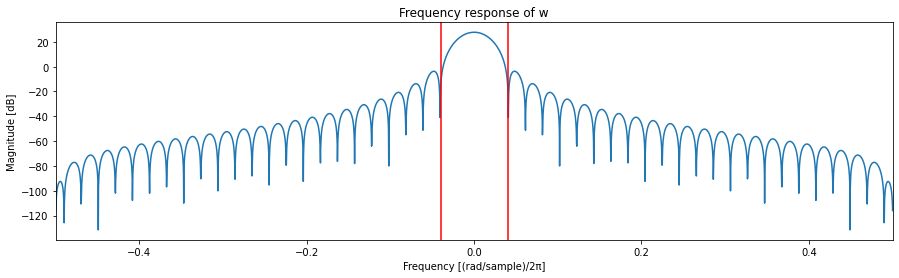

In [124]:
# Defines a Hanning window of length 50
Nw = 50                                 
w = Signal("w", np.hanning(Nw))

# Lower and upper limits of the main lobe (so width = 4/Nw)
xhighlights = [-2/Nw, 2/Nw]

# Plots the DTF of w
w.fft_plot(xhighlights=xhighlights)

# 3.1.b

The STFT referred to as low-pass convention is defined in discrete time as:

$$W_x(\lambda,b)=\sum_{n\in \mathbb Z} x(n)w(n-b)e^{-j2\pi\lambda n}$$

In this equation we consider the input signal $x(n)$ and the analysis window in discrete time $w(n-b)$ (where $b$ is a discret and quantized variable) to obtain the filter-bank interpretation. The spectrum of the signal $x$  is first rotated along unit circle in the $z$ plane in that way we shift $\lambda$ frecuency down to 0. Then, we can see the input signal as:

$$x(n)\overset{\Delta}{=} x(n)e^{-j2\pi\lambda n}$$

Additionally, the signal is convolved with the window to get $W_x(b)$:

$$W_x(b)=\sum_{n\in \mathbb Z} x(n)w(n-b)= (x \ast w)(b)$$

At this point, we consider the window $w$ as a low pass filter impulse response. The output $W_x$ is a time-domain signal with a centered componend $e^{-j2\pi\lambda n}$ removed by frecuency shifting. Since the analysis of the STFT is symetric and the lenght of the impulse response is odd, then we conlude that is a Type I filter, in the case of an even impulse response we define a Type II filter.

<br>

# 3.1.c

Starting by the given expression:

$$\tilde{X}(\lambda,b)=\sum_{n\in \mathbb Z} x(n+b)w(n-b)e^{-j2\pi\lambda n}$$

Doing $m=n+b$:

$$\tilde{X}(\lambda,b)=\sum_{m\in \mathbb Z} x(m)w(m-b)e^{-j2\pi\lambda (m-b)}$$
$$\tilde{X}(\lambda,b)=\sum_{m\in \mathbb Z} x(m)w(m-b)e^{-j2\pi\lambda m}e^{j2\pi\lambda b}$$
$$\tilde{X}(\lambda,b)=e^{j2\pi\lambda b} \sum_{m\in \mathbb Z} x(m)w(m-b)e^{-j2\pi\lambda m}$$
$$\tilde{X}(\lambda,b)=e^{j2\pi\lambda b} W_x(\lambda,b)$$

<br>

# 3.1.d

In [125]:
# Defines the variables k, R and M as requested
k = 3     # Index of the frequency channel
R = 1     # Hop size (increment on analysis times)
M = 32    # TDF order

# Defines a Hanning window of length 31 (< M)
Nw = 31
w = Signal("w", data=np.hanning(Nw))

# Number of tdf's to calculate
Nt = int((len(x.data)-Nw)/R)

# Calculates Xtil
Xtil = np.zeros((M, Nt), dtype=complex)
for u in np.arange(0, Nt).reshape(-1):
    term = np.multiply(x.data[np.arange(int(u*R+1), int(u*R+1+Nw))], w.data)
    Xtil[:, u] = np.fft.fft(term, M)

# Listen to the real part of xk (with k=3)
rexk = np.real(Xtil[k, :])
rexk = Signal("rexk", data=rexk, freq=x.freq)
#rexk.listen()

# Plot rexk's spectrogram
#rexk.spectrogram_plot()

c:\Users\Dell\Desktop\Code\Telecom\2A\P1\TSIA201\TP1\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [126]:
# Now, we can check the filter equivalence. As we fixed k=3 on last part, this is equal to getting a band-pass filter centered on 4500. We used a butterworth filter to generate the filter and then we used filtfilt as it was suggested as a better approach on scipy's website.
f_desired = 4500
f_total = 48000

# Obtain filter's coefficients
filter_1, filter_2 = sig.butter(9, [2*f_desired/f_total-2.5/(Nw), 2*f_desired/f_total+2.5/(Nw)], btype='band')
y = sig.filtfilt(filter_1, filter_2, x.signal, axis=0)
y = Signal("y", y, 48000)

y.spectrogram_plot()

AttributeError: &#39;Signal&#39; object has no attribute &#39;signal&#39;

# 3.2.e

From the definition of an overlap-add operation:
\begin{equation}
\begin{split}
y(n)&= \sum_{u \in \mathbb Z} y_s(u,n-uR)\\
&= \sum_{u \in \mathbb Z} \left( \frac{1}{M} \sum_{k=0}^{M-1} \tilde{X}_{k,u}e^{j2\pi\frac{k(n-uR)}{m}}w_{s}(n-uR)\right)\\
&= \sum_{u \in \mathbb Z} \left[ \frac{1}{M} \sum_{k=0}^{M-1} \left(\sum_{m\in \mathbb Z}x_{(m)}w_{(m-uR)}e^{-j2\pi\frac{k(m-uR)}{M}}\right)e^{j2\pi\frac{k(n-uR)}{M}}w_{s_{(n-uR)}}\right]\\
&= \sum_{u \in \mathbb Z} \left[ \frac{1}{M} \sum_{k=0}^{M-1} \sum_{m\in \mathbb Z}x_{(m)}w_{(m-uR)}e^{-j2\pi\frac{k(m-uR)}{M}}e^{j2\pi\frac{k(n-uR)}{M}}w_{s_{(n-uR)}}\right]\\
&= \sum_{u \in \mathbb Z} \left[ \frac{1}{M} \sum_{k=0}^{M-1} \sum_{m\in \mathbb Z}x_{(m)}w_{(m-uR)}w_{s_{(n-uR)}}e^{j2\pi\frac{k(n-m)}{M}}\right]\\
&= \sum_{u \in \mathbb Z} \left[ \frac{1}{M} \sum_{m\in \mathbb Z} \sum_{k=0}^{M-1} x_{(m)}w_{(m-uR)}w_{s_{(n-uR)}}e^{j2\pi\frac{k(n-m)}{M}}\right]\\
&= \sum_{u \in \mathbb Z} \left[ \frac{1}{M} \sum_{m\in \mathbb Z} x_{(m)}w_{(m-uR)}w_{s_{(n-uR)}}\sum_{k=0}^{M-1}e^{j2\pi\frac{k(n-m)}{M}}\right]\\
\end{split}
\end{equation}

If $m \ne n$, we can write

\begin{equation}
\begin{split}
&= \sum_{u \in \mathbb Z} \left[ \frac{1}{M} \sum_{m\in \mathbb Z}  x_{(m)}w_{(m-uR)}w_{s_{(n-uR)}}\frac{1-e^{j2\pi k(n-m)}}{1-e^{j2\pi\frac{k(n-m)}{M}}}\right]\\
\end{split}
\end{equation}

Noting that $e^{j2\pi k(n-m)}$ is a M-unitary root, then, if $m\ne n$, $e^{j2\pi k(n-m)}=1$. Which give us:

$$\frac{1-e^{j2\pi k(n-m)}}{1-e^{j2\pi\frac{k(n-m)}{M}}}=0 \ \ \ \ \ for \ \ n\ne m$$

Then, if $m=n$ 

$$\sum_{k=0}^{M-1} e^{j2\pi\frac{k(n-m)}{M}}= \sum_{k=0}^{M-1}1 = M$$

Therefore, we can write:

$$y(m)=\sum_{u \in \mathbb Z} \left( \frac{1}{M} \sum_{m \in \mathbb Z} X_{(m)}w(m-uR)w_{s}{(n-uR)}M \delta_{m,n}\right)$$

So, we can consider only $m=n$ $(\delta_{m,n}=1)$

\begin{equation}
\begin{split}
y(n)&= \sum_{u \in \mathbb Z} \left[\frac{M}{M} x(n) w(n-uR) w_s(n-uR)\right]\\
&=\sum_{u \in \mathbb Z} x(n)w(n-uR)w_s(n-uR) \\
&= x(n) \sum_{u \in \mathbb Z}w(n-uR)w_s(m-uR)
\end{split}
\end{equation}

For perfect reconstruction $x(n)=y(n)$

$$1=\sum_{u \in \mathbb Z}w(n-uR)w_s(m-uR)\overset{\Delta}{=} f(n)$$

therefore $f(n)=1$  $\forall$ $n$.

<br>

# 3.2.f

c:\Users\Dell\Desktop\Code\Telecom\2A\P1\TSIA201\TP1\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
&lt;ipython-input-132-9029c51e4145&gt;:34: ComplexWarning: Casting complex values to real discards the imaginary part
  X[np.arange(deb.astype(int),fin.astype(int))] = X[np.arange(deb.astype(int),fin.astype(int))] + tx


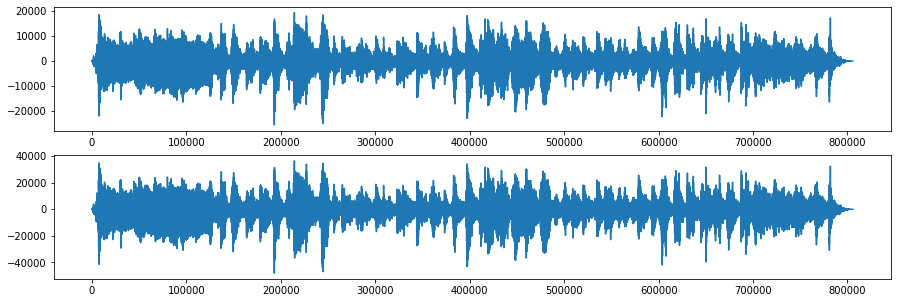

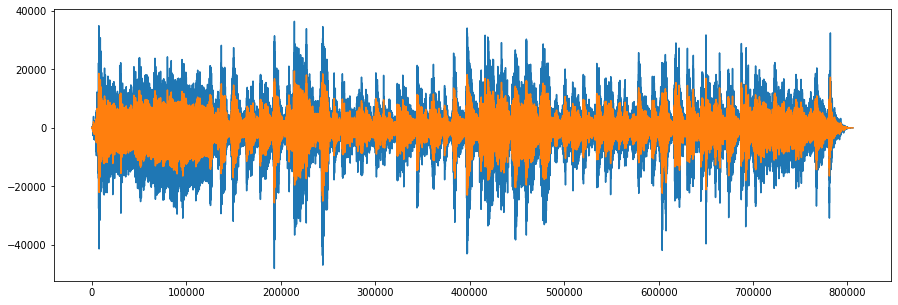

In [132]:
N = x.data.shape[0]
# Defines a Hanning window of length 31
Nw = 31
w = Signal("w", np.hanning(Nw))
 
# Defines the variables k, R and M as requested
M = 32    # TDF order
k = 3     # Index of the frequency channel
R = ceil(M/2/k)     # Hop size (increment on analysis times)
L = M/2+1

# Number of tdf's to calculate
Nt = int((len(x.data)-Nw)/R)

# Calculates Xtil
Xtil = np.zeros((M, Nt), dtype=complex)
for u in np.arange(0, Nt).reshape(-1):
    term = np.multiply(x.data[np.arange(int(u*R+1), int(u*R+1+Nw))], w.data)
    Xtil[:, u] = np.fft.fft(term, M)
    
def reconst(xtilde,w,R=1, M=32, Nw=31, N=1):
    X = np.zeros(N)
    for b in np.arange(0,xtilde.shape[1]):
        
        deb = R*b + 1 # début de trame
        fin = deb + Nw # fin de trame
        
        bx = xtilde[:,b]
        inv = np.fft.ifft(bx)
        
        tx = np.multiply(inv[:Nw],w.data)
        
        
        X[np.arange(deb.astype(int),fin.astype(int))] = X[np.arange(deb.astype(int),fin.astype(int))] + tx
        

    return X

X = reconst(Xtil, w, R=R, M=M, Nw=Nw,N=N)
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(x.data)
plt.subplot(2,1,2)
plt.plot(X)

plt.figure(figsize=(15,5))
plt.plot(X)
plt.plot(x.data)
plt.show()

# 3.3.g

In [133]:
def equalizer(xtilde, weights):
    a = xtilde.copy()
    for k in np.arange(0, int(xtilde.shape[0])-1):
        a[k,:] = xtilde[k,:]*weights[k]
    return a

weights = np.ones(int(M/2)+1)

weights[7:-1]=0
weights[10]=0
weights[11]=0
weights[12]=0
weights[13]=0
weights[14]=0


b = np.real(Xtil).copy()
Y = equalizer(b,weights)

Y2 = reconst(Y, w, R=R, M=M, Nw=Nw,N=N)
Y2 = Y2 * max(x)/max(Y2)

Y2 = Signal("Y2", Y2, 48000)
Y2.listen()

c:\Users\Dell\Desktop\Code\Telecom\2A\P1\TSIA201\TP1\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndexError: index 17 is out of bounds for axis 0 with size 17

c:\Users\Dell\Desktop\Code\Telecom\2A\P1\TSIA201\TP1\venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


805733